<p style="font-size:32px;text-align:center"> <b>Disneyland Reviews</b> </p>

# Data

The dataset includes 42000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.

Column Description:

1. Review_ID: unique id given to each review
2. Rating: ranging from 1 (unsatisfied) to 5 (satisfied)
3. Year_Month: when the reviewer visited the theme park
4. Reviewer_Location: country of origin of visitor
5. Review_Text: comments made by visitor
6. Disneyland_Branch: location of Disneyland Park


# Importing the Libraries and Data

In [1]:
#General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
sns.set()

import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
tqdm.pandas()
import scikitplot as skplt

#Libraries to clean text
import re
from cleantext import clean
import os
from bs4 import BeautifulSoup

#Libraries for NLP
import nltk
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob, Word
import spacy
from PIL import Image

#Libraries for building models
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score
from prettytable import PrettyTable, MSWORD_FRIENDLY, DEFAULT

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('DisneylandReviews.csv')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [3]:
df.shape

(42656, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
df.nunique()

Review_ID            42636
Rating                   5
Year_Month             112
Reviewer_Location      162
Review_Text          42632
Branch                   3
dtype: int64

# Cleaning the Dataset

In [6]:
df.drop(df[df.Year_Month=='missing'].index, inplace=True)

In [7]:
df.shape

(40043, 6)

In [8]:
df.Branch.unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [9]:
df.Branch = df.Branch.apply(lambda x: re.sub('Disneyland_', '', x))

In [10]:
new = df.Year_Month.str.split('-', n=1, expand=True)
df['Year'] = new[0]
df['Month'] = new[1]
df.drop(columns=['Year_Month'], inplace=True)
df.head()

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


In [11]:
df.Year = df.Year.astype(int)
df.Month = df.Month.astype(int)

In [12]:
df.Month.unique()

array([ 4,  5,  3,  9,  1, 11, 12,  6,  2, 10,  8,  7])

In [13]:
def quarter(month):
    if month <=3:
        return 1
    elif month >3 and month <=6:
        return 2
    elif month >6 and month <=9:
        return 3
    else:
        return 4

In [14]:
# Use 'apply' with tqdm
df['Quarter'] = df.Month.progress_apply(quarter)

100%|██████████| 40043/40043 [00:00<00:00, 853794.69it/s]


In [15]:
df.drop_duplicates(subset='Review_Text', inplace=True, ignore_index=True)

In [16]:
df.drop_duplicates(subset='Review_ID', inplace=True, ignore_index=True)

In [17]:
df.shape

(40014, 8)

In [18]:
df.reset_index(drop=True)

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Quarter
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,2
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,2
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,2
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,2
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,2
...,...,...,...,...,...,...,...,...
40009,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Paris,2011,1,1
40010,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Paris,2011,1,1
40011,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Paris,2010,12,4
40012,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Paris,2010,12,4


In [19]:
df['Review_Length'] = df.Review_Text.apply(lambda x: len(x))

# Preprocessing the Text Data

In [20]:
#Modifying the NLTK stop words
stop_words = set(stopwords.words('english'))

#Remove words that are in NLTK stopwords list
not_stopwords = {'not', 'no', 'nor'} 
final_stop_words = list(set([word for word in stop_words if word not in not_stopwords]))
final_stop_words.sort()

print(final_stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than'

In [21]:
nlp = spacy.load('en_core_web_lg')

In [22]:
def preprocess_text1(x):
    
    #Convert the string to lowercase
    x = str(x).lower()
    
    #Replace the contracted words
    x = x.replace("’", "'").replace("won't", "will not").replace("can't", "can not").replace("n't", " not")\
        .replace("'s", "is").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("%", " percent ").replace("$", " dollar ").replace("€", " euro ").replace("'ll", " will")\
        .replace("n't", "not").replace("shan't", "shall not").replace("yr", "year")
    
    #Clean the strings
    x = re.sub('[^a-zA-Z0-9 ]', '', x)
    x = re.sub(' +', ' ', x)
    
    return x

In [23]:
df.Review_Text = df.Review_Text.progress_apply(preprocess_text1)

100%|██████████| 40014/40014 [00:02<00:00, 16572.10it/s]


In [24]:
def preprocess_text2(x):
    
    #Lemmatization
    doc = nlp(x)
    x = ' '.join([token.lemma_ for token in doc])
    
    #Removing the stopwords
    x = ' '.join([token.text for token in doc if token.text not in final_stop_words])
    
    return x

In [25]:
df.Review_Text = df.Review_Text.progress_apply(preprocess_text2)

100%|██████████| 40014/40014 [16:34<00:00, 40.23it/s]


In [26]:
def polarity(x):
    text = TextBlob(x)
    return text.sentiment.polarity

def subjectivity(x):
    text = TextBlob(x)
    return text.sentiment.subjectivity

In [27]:
df['Polarity'] = df.Review_Text.progress_apply(polarity)
df['Subjectivity'] = df.Review_Text.progress_apply(subjectivity)

100%|██████████| 40014/40014 [00:23<00:00, 1737.01it/s]


In [28]:
def review(rating):
    if rating <3:
        return 'Negative'
    elif rating==3:
        return 'Neutral'
    else:
        return 'Positive'

In [29]:
df['Review'] = df.Rating.progress_apply(review)

100%|██████████| 40014/40014 [00:00<00:00, 853332.52it/s]


In [30]:
df.tail()

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Quarter,Review_Length,Polarity,Subjectivity,Review
40009,92198076,4,United Kingdom,although pick prompt taxi driver nt sure time ...,Paris,2011,1,1,1574,0.050476,0.402169,Positive
40010,92061774,4,Germany,returned 4 days family trip disneyland two boy...,Paris,2011,1,1,3593,0.182696,0.392499,Positive
40011,91995748,1,United Kingdom,spent 20 dec 2010 disney park lunchtime attrac...,Paris,2010,12,4,2537,0.006901,0.457556,Negative
40012,91984642,2,United Kingdom,well really looking forward trip christmas per...,Paris,2010,12,4,1758,0.064015,0.438194,Negative
40013,91827418,5,United Kingdom,staying disney hotel make good use extra hours...,Paris,2010,9,3,512,0.115000,0.445000,Positive


# Exploratory Data Analysis

<AxesSubplot:>

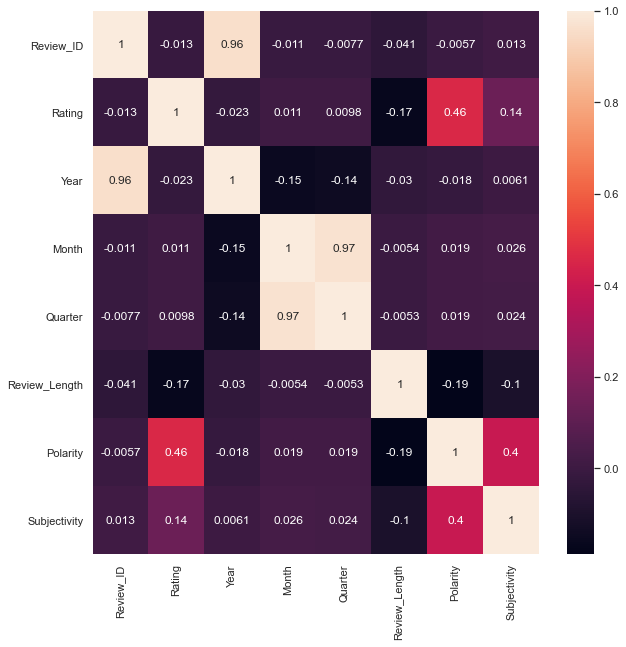

In [31]:
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True)

## Reviews by Years

Text(0.5, 1.0, 'Reviews per Year')

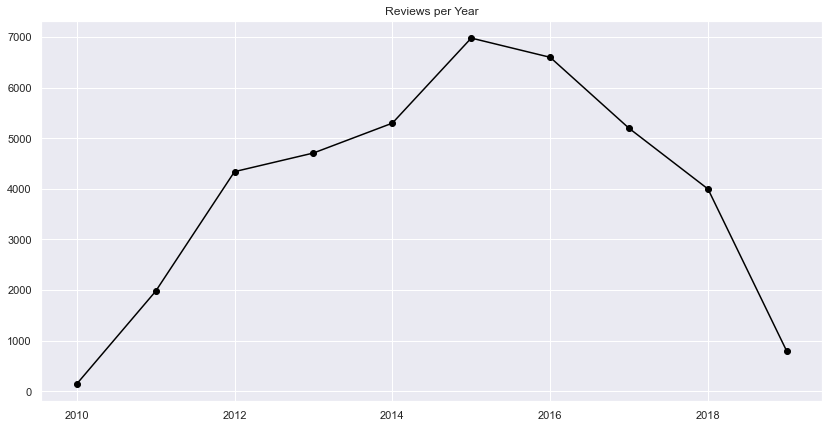

In [32]:
df1 = df.groupby(by='Year', as_index=False).agg({'Review_Length':'count'})
sns.set_style('darkgrid')
plt.figure(figsize=(14,7))
plt.plot(df1['Year'], df1['Review_Length'], marker='o', color='black')
plt.title('Reviews per Year')

Most number of reviews were written in **Year 2015.**

## Visits to Each Branches per Year

Text(0.5, 1.0, 'Visits to Each Branches per Year')

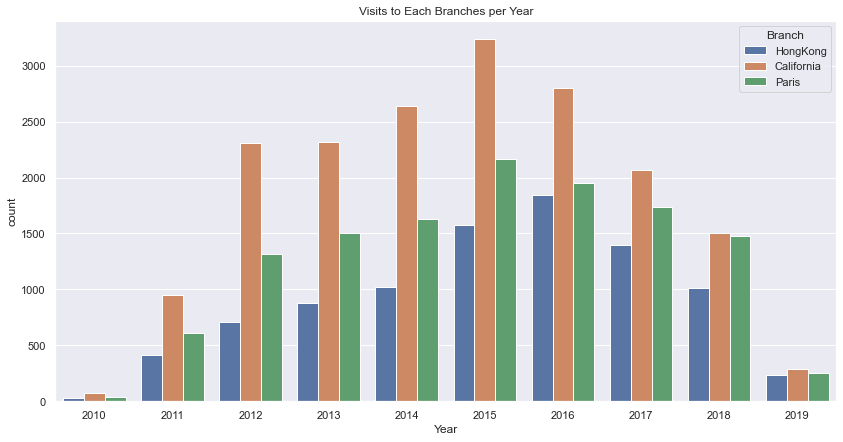

In [33]:
plt.figure(figsize=(14,7))
plots = sns.countplot(x='Year', data=df, hue='Branch')
plt.title('Visits to Each Branches per Year')

## Rating vs Quarter

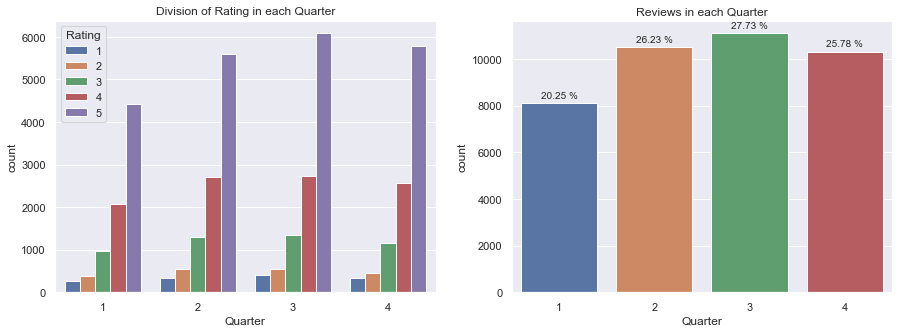

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
plots = sns.countplot(ax=axes[0],x='Quarter', data=df, hue='Rating')
axes[0].set_title('Division of Rating in each Quarter')

plots = sns.countplot(ax=axes[1],x='Quarter', data=df)
axes[1].set_title('Reviews in each Quarter')

for bar in plots.patches:
    plots.annotate(f'{round(bar.get_height()/len(df)*100,2)} %', xy=(bar.get_x() + bar.get_width() / 2,  
                   bar.get_height()), ha='center', va='center', size=10, xytext=(0, 8), textcoords='offset points')


Least number of reviews are given in **1st Quarter.**

## Average Rating by Country

In [35]:
df4 = df.groupby(by='Reviewer_Location', as_index=False).agg({'Rating':'mean'}).sort_values(by='Rating')
df4.style.background_gradient(subset=['Rating'])

,Reviewer_Location,Rating
3,Andorra,2.000000
147,Turks and Caicos Islands,2.000000
132,South Sudan,2.000000
136,Suriname,2.000000
39,Ecuador,2.333333
58,Haiti,3.000000
129,Solomon Islands,3.000000
107,Northern Mariana Islands,3.000000
36,Democratic Republic of the Congo,3.000000
128,Slovenia,3.000000


## Reviews by each Branch

Text(0.5, 1.0, 'Reviews by each Branch')

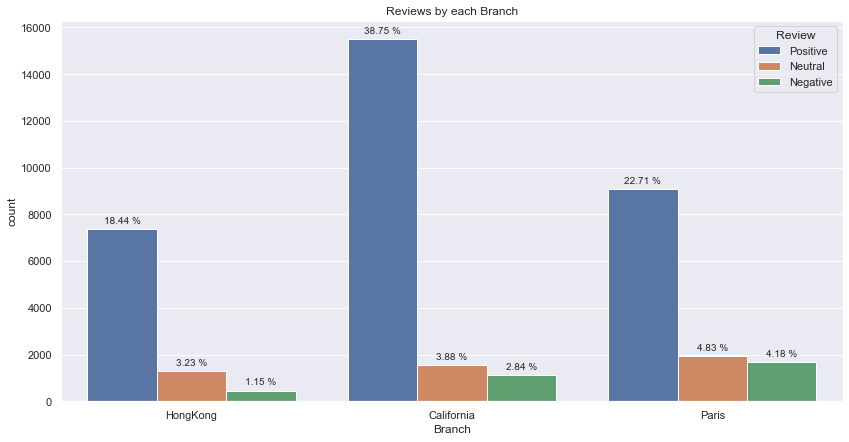

In [36]:
plt.figure(figsize=(14,7))
plots = sns.countplot(x='Branch', hue='Review', data=df)

for bar in plots.patches:
    plots.annotate(f'{round(bar.get_height()/len(df)*100,2)} %', xy=(bar.get_x() + bar.get_width() / 2,  
                   bar.get_height()), ha='center', va='center', size=10, xytext=(0, 8), textcoords='offset points')

plt.title('Reviews by each Branch')

## Most Occuring Words in the Corpus

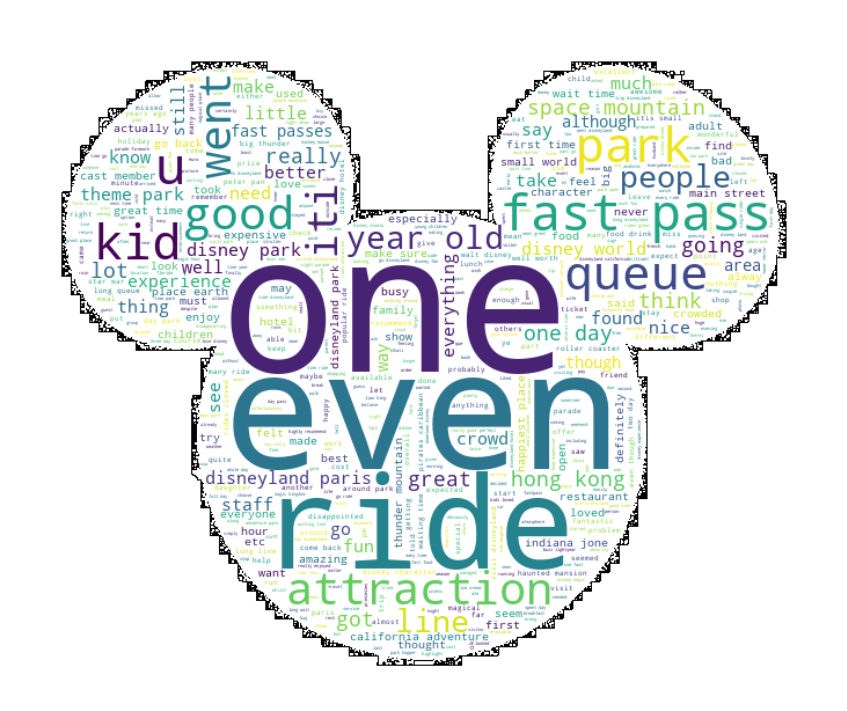

In [37]:
df['Review_Text']=df['Review_Text'].astype('str')
Reviews_Text = " ".join(txt for txt in df.Review_Text)
c_mask = np.array(Image.open("mickey mouse.jpg"))

wc = WordCloud(background_color='white', mask=c_mask, mode='RGB', width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='black')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Positive" Reviews

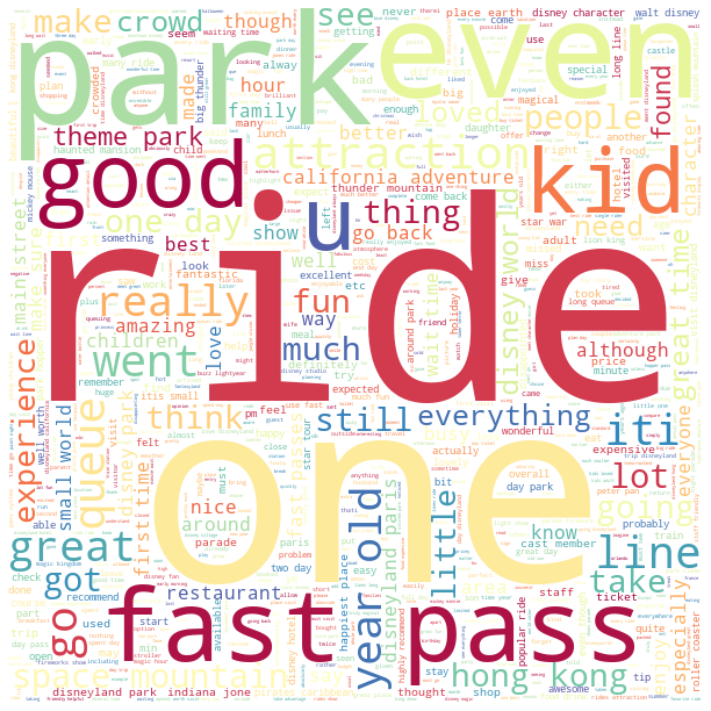

In [38]:
df_pos = df.loc[df['Review']=='Positive']
Reviews_Text = " ".join(insul for insul in df_pos.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Negative" Reviews

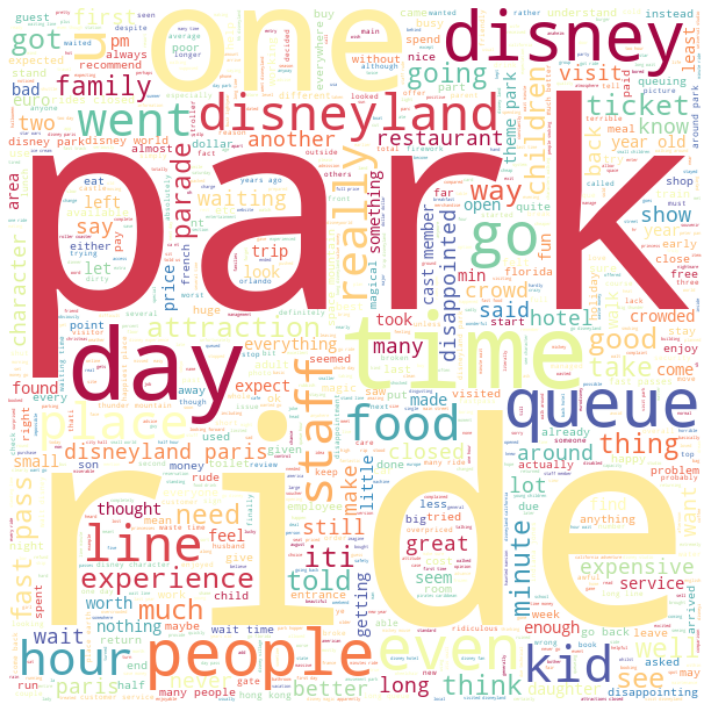

In [39]:
df_neg = df.loc[df['Review']=='Negative']
Reviews_Text = " ".join(insul for insul in df_neg.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Most Occuring Words in the "Neutral" Reviews

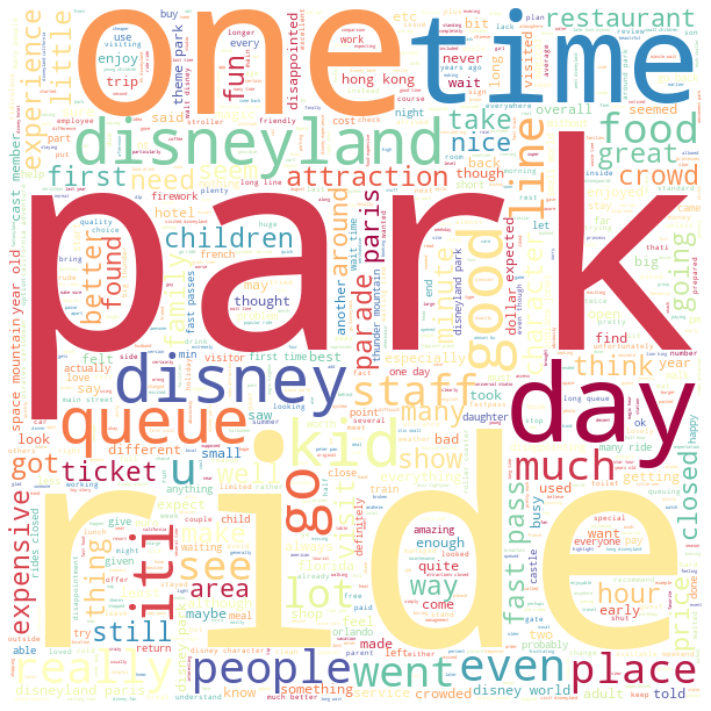

In [40]:
df_neu = df.loc[df['Review']=='Neutral']
Reviews_Text = " ".join(insul for insul in df_neu.Review_Text)

wc = WordCloud(background_color='white', mode='RGB', width=600, max_words=1000, height=600,
               random_state=1, contour_width=1, contour_color='green', colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

# Machine Learning Models

## Splitting the dataset

Splitting the dataset into train, cv and test in 64:16:20.

In [41]:
df.drop(columns=['Quarter', 'Review_ID', 'Rating'], inplace=True)

In [42]:
y = df['Review']
x = df.drop(columns=['Review'])

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [44]:
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(25608, 8)
(6403, 8)
(8003, 8)


In [45]:
y_train.value_counts()

Positive    20460
Neutral      3058
Negative     2090
Name: Review, dtype: int64

In [46]:
text_train = x_train.Review_Text.tolist()
text_cv = x_cv.Review_Text.tolist()
text_test = x_test.Review_Text.tolist()

## Encoding and Normalization of Columns

In [47]:
le = LabelEncoder()
le.fit(y_train.values)

y_train = le.transform(y_train.values)
y_cv = le.transform(y_cv.values)
y_test = le.transform(y_test.values)

### TFIDF-W2V

In [48]:
# https://github.com/geofflobo12/Ouora_Question_Pair_Similarity/blob/master/3.Quora_ML_Models.ipynb for tfidf w2v
vec = TfidfVectorizer()
vec.fit(text_train)

x_train_text = vec.transform(text_train)

word2tfidf = dict(zip(vec.get_feature_names(), vec.idf_))

In [49]:
def vectors(r_text):
    vecs = []
    
    for sent in tqdm(r_text):
        doc = nlp(sent)
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        
        for word in doc:
            vect = word.vector
            
            try:
                idf = word2tfidf[str(word)]
            except:
                idf = 0
            mean_vec += vect * idf
            
            
        mean_vec = mean_vec.mean(axis=0) 
        vecs.append(mean_vec)
    return vecs

In [50]:
x_train_text = np.array(vectors(text_train))
x_cv_text = np.array(vectors(text_cv))
x_test_text = np.array(vectors(text_test))

print(x_train_text.shape)

100%|██████████| 8003/8003 [02:20<00:00, 57.07it/s]

(25608, 300)


In [51]:
ce = BinaryEncoder(cols=['Reviewer_Location'], return_df=False)
ce.fit(x_train)
print(x_train.shape, y_train.shape)

x_train_loc = ce.transform(x_train)
x_cv_loc = ce.transform(x_cv)
x_test_loc = ce.transform(x_test)

print('After vectorization...')
print(x_train_loc.shape, y_train.shape)
print(x_cv_loc.shape, y_cv.shape)
print(x_test_loc.shape, y_test.shape)

(25608, 8) (25608,)
After vectorization...
(25608, 16) (25608,)
(6403, 16) (6403,)
(8003, 16) (8003,)


In [52]:
x_train_loc = x_train_loc[ :, 0:9]
x_cv_loc = x_cv_loc[ :, 0:9]
x_test_loc = x_test_loc[ :, 0:9]

print(x_train_loc.shape, y_train.shape)
print(x_cv_loc.shape, y_cv.shape)
print(x_test_loc.shape, y_test.shape)

(25608, 9) (25608,)
(6403, 9) (6403,)
(8003, 9) (8003,)


In [53]:
ohe = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), ['Branch']), ('sca', MinMaxScaler(), ['Year', 'Month', 'Review_Length', 'Polarity', 'Subjectivity'])], remainder='drop')
ohe.fit(x_train)
print(x_train.shape, y_train.shape)

x_train_ohe = ohe.transform(x_train)
x_cv_ohe = ohe.transform(x_cv)
x_test_ohe = ohe.transform(x_test)

print('After vectorization...')
print(x_train_ohe.shape, y_train.shape)
print(x_cv_ohe.shape, y_cv.shape)
print(x_test_ohe.shape, y_test.shape)

(25608, 8) (25608,)
After vectorization...
(25608, 8) (25608,)
(6403, 8) (6403,)
(8003, 8) (8003,)


### Combining all encoded and normalized data

In [54]:
x_tr = np.hstack((x_train_text.astype(np.float), x_train_loc.astype(np.float), x_train_ohe.astype(np.float)))
x_cv = np.hstack((x_cv_text.astype(np.float), x_cv_loc.astype(np.float), x_cv_ohe.astype(np.float)))
x_te = np.hstack((x_test_text.astype(np.float), x_test_loc.astype(np.float), x_test_ohe.astype(np.float)))

In [55]:
smt = SMOTE(random_state=42, n_jobs=-1)
x_tr, y_train = smt.fit_resample(x_tr, y_train)


print("Final Data Matrix Shape is........")
print(x_tr.shape,y_train.shape)
print(x_cv.shape,y_cv.shape)
print(x_te.shape,y_test.shape)

Final Data Matrix Shape is........
(61380, 317) (61380,)
(6403, 317) (6403,)
(8003, 317) (8003,)


In [57]:
pd.DataFrame(y_train).value_counts()

0    20460
1    20460
2    20460
dtype: int64

In [58]:
def cnf_matrix(true_y, pred_y):

    # Confusion Matrix
    cf_matrix = confusion_matrix(true_y, pred_y)
    print('-'*40, 'Confusion Matrix', '-'*40)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="YlGnBu", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Precision Matrix
    pc_matrix =(cf_matrix/cf_matrix.sum(axis=0))
    print("-"*40, "Precision matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(5,5))
    sns.heatmap(pc_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Recall Matrix
    rl_matrix =(((cf_matrix.T)/(cf_matrix.sum(axis=1))).T)
    print("-"*40, "Recall matrix (Row sum=1)", "-"*40)
    plt.figure(figsize=(5,5))
    sns.heatmap(rl_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')

## Random Model and its Performance

Log loss on Cross Validation Data using Random Model 1.3443858797527337
Log loss on Test Data using Random Model 1.3434404297292963
ROC-AUC Score on Cross Validation Data using Random Model 0.5080659853099111
ROC-AUC Score on Test Data using Random Model 0.5112629949730763


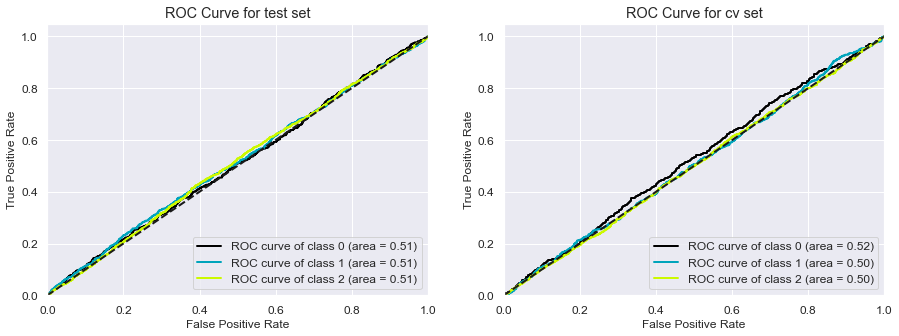

---------------------------------------- Confusion Matrix ----------------------------------------


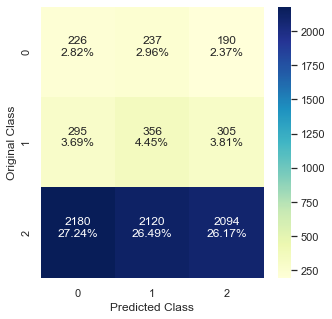

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


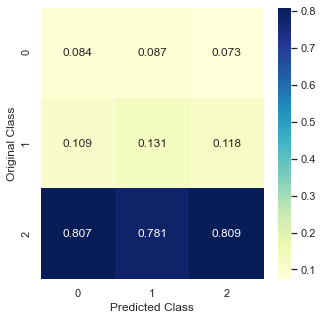

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


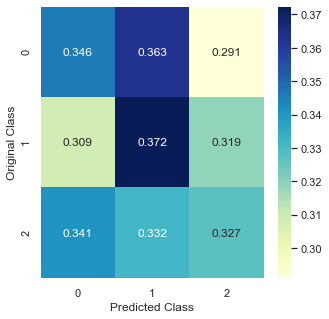

In [59]:
test_data_len = x_te.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,3))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,3)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])



# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,3))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,3)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])


predicted_y = np.argmax(test_predicted_y, axis=1)
predicted_cv = np.argmax(cv_predicted_y, axis=1)

ll_rm_cv = log_loss(y_cv,cv_predicted_y, eps=1e-15)
roc_rm_cv = roc_auc_score(y_cv, cv_predicted_y, multi_class='ovr')
ll_rm_te = log_loss(y_test,test_predicted_y, eps=1e-15)
roc_rm_te = roc_auc_score(y_test, test_predicted_y, multi_class='ovr')

print("Log loss on Cross Validation Data using Random Model",ll_rm_cv)
print("Log loss on Test Data using Random Model",ll_rm_te)
print("ROC-AUC Score on Cross Validation Data using Random Model",roc_rm_cv)
print("ROC-AUC Score on Test Data using Random Model",roc_rm_te)

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, test_predicted_y, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, cv_predicted_y, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, predicted_y)

## Logistic Regression

### Hyperparameter Tuning

In [60]:
alpha = [10 ** x for x in range(-6, 4)]
params = {'alpha':alpha}
clf1 = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
r_search = RandomizedSearchCV(clf1, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1,
                                           random_state=42),
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   random_state=42, return_train_score=True)

In [61]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'alpha': 1} at which the score is 0.6947051156728576


### Training the Model

In [62]:
clf1 = SGDClassifier(loss='log', n_jobs=-1, random_state=42, **r_search.best_params_)
clf1.fit(x_tr, y_train)
cal_clf1 = CalibratedClassifierCV(clf1, cv='prefit')
cal_clf1.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, loss='log',
                                                    n_jobs=-1,
                                                    random_state=42),
                       cv='prefit')

In [63]:
y_pred_tr = cal_clf1.predict(x_tr)
y_prob_tr = cal_clf1.predict_proba(x_tr)
y_pred_cv = cal_clf1.predict(x_cv)
y_prob_cv = cal_clf1.predict_proba(x_cv)
y_pred = cal_clf1.predict(x_te)
y_prob = cal_clf1.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Logistic Regression 0.7215505209023482
Log loss on Cross Validation Data using Logistic Regression 0.6860269728863836
Log loss on Test Data using Logistic Regression 0.690329545657177
ROC-AUC Score on Train Data using Logistic Regression 0.8635796571332471
ROC-AUC Score on Cross Validation Data using Logistic Regression 0.8103416966150007
ROC-AUC Score on Test Data using Logistic Regression 0.8102527921354813


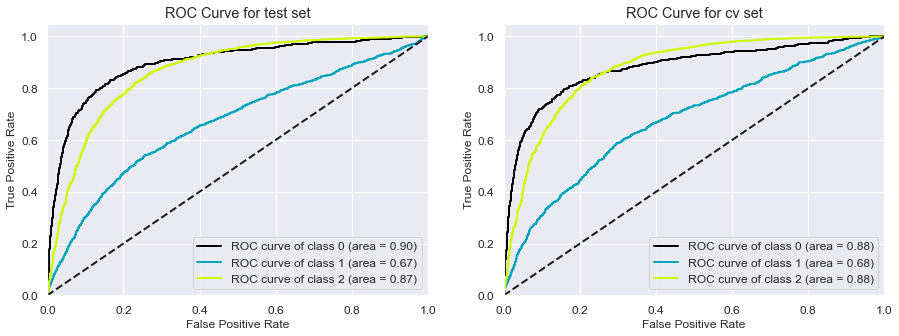

---------------------------------------- Confusion Matrix ----------------------------------------


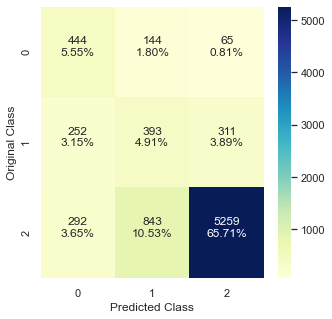

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


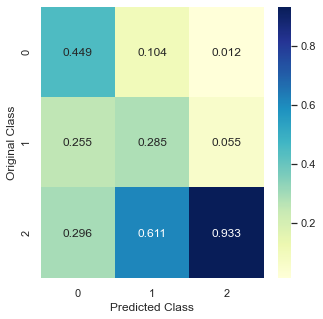

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


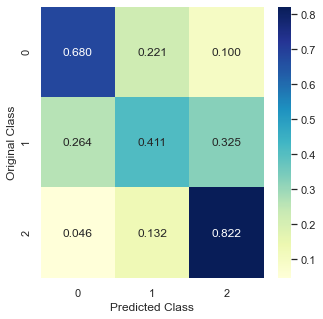

In [64]:
ll_lg_tr = log_loss(y_train, y_prob_tr, labels=cal_clf1.classes_, eps=1e-15)
ll_lg_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf1.classes_, eps=1e-15)
ll_lg_te = log_loss(y_test, y_prob, labels=cal_clf1.classes_, eps=1e-15)
roc_lg_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_lg_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_lg_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Logistic Regression",ll_lg_tr)
print("Log loss on Cross Validation Data using Logistic Regression",ll_lg_cv)
print("Log loss on Test Data using Logistic Regression",ll_lg_te)
print("ROC-AUC Score on Train Data using Logistic Regression",roc_lg_tr)
print("ROC-AUC Score on Cross Validation Data using Logistic Regression",roc_lg_cv)
print("ROC-AUC Score on Test Data using Logistic Regression",roc_lg_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Naive Bayes

### Hyperparameter Tuning

In [72]:
var_smoothing = np.logspace(0,-9, num=100)
params = {'var_smoothing':var_smoothing}
clf2 = GaussianNB()
r_search = RandomizedSearchCV(clf2, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42, return_train_score=True)

In [73]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'var_smoothing': 2.848035868435799e-08} at which the score is 0.4383512544802867


### Training the model

In [74]:
clf2 = GaussianNB(**r_search.best_params_)
clf2.fit(x_tr, y_train)
cal_clf2 = CalibratedClassifierCV(clf2, cv='prefit')
cal_clf2.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=GaussianNB(var_smoothing=2.848035868435799e-08),
                       cv='prefit')

In [75]:
y_pred_tr = cal_clf2.predict(x_tr)
y_prob_tr = cal_clf2.predict_proba(x_tr)
y_pred_cv = cal_clf2.predict(x_cv)
y_prob_cv = cal_clf2.predict_proba(x_cv)
y_pred = cal_clf2.predict(x_te)
y_prob = cal_clf2.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Naive Bayes 1.0539084727949786
Log loss on Cross Validation Data using Naive Bayes 1.0366658985923993
Log loss on Test Data using Naive Bayes 1.0297986317146668
ROC-AUC Score on Train Data using Naive Bayes 0.6617117643578597
ROC-AUC Score on Cross Validation Data using Naive Bayes 0.7206286703103147
ROC-AUC Score on Test Data using Naive Bayes 0.723296902260541


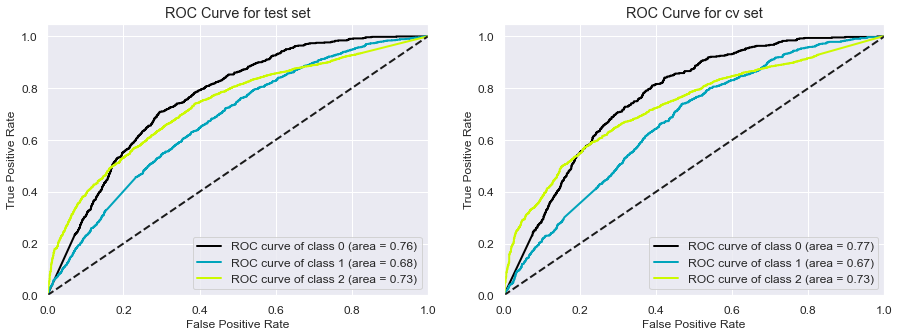

---------------------------------------- Confusion Matrix ----------------------------------------


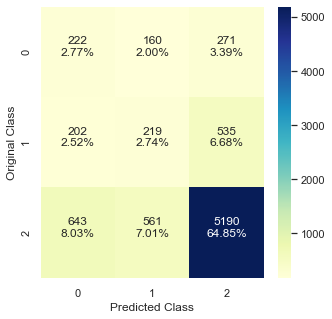

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


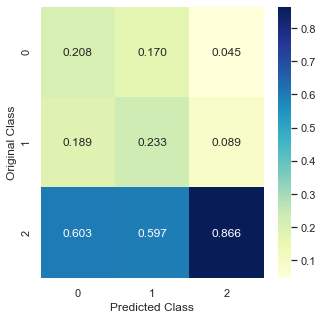

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


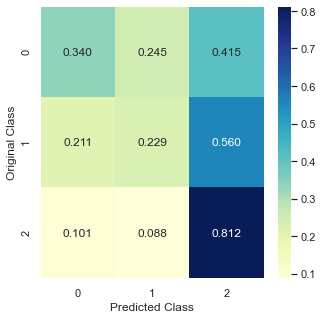

In [76]:
ll_nb_tr = log_loss(y_train, y_prob_tr, labels=cal_clf2.classes_, eps=1e-15)
ll_nb_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf2.classes_, eps=1e-15)
ll_nb_te = log_loss(y_test, y_prob, labels=cal_clf2.classes_, eps=1e-15)
roc_nb_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_nb_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_nb_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Naive Bayes",ll_nb_tr)
print("Log loss on Cross Validation Data using Naive Bayes",ll_nb_cv)
print("Log loss on Test Data using Naive Bayes",ll_nb_te)
print("ROC-AUC Score on Train Data using Naive Bayes",roc_nb_tr)
print("ROC-AUC Score on Cross Validation Data using Naive Bayes",roc_nb_cv)
print("ROC-AUC Score on Test Data using Naive Bayes",roc_nb_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Support Vector Machines

### Hyperparameter Tuning

In [77]:
alpha = [10 ** x for x in range(-6, 4)]
params = {'alpha':alpha}
clf3 = SGDClassifier(loss='hinge', n_jobs=-1, random_state=42)
r_search = RandomizedSearchCV(clf3, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=SGDClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'alpha': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1, 10, 100,
                                                  1000]},
                   random_state=42, return_train_score=True)

In [78]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'alpha': 1} at which the score is 0.6897360703812316


### Training the model

In [79]:
clf3 = SGDClassifier(loss='hinge', n_jobs=-1, random_state=42, **r_search.best_params_)
clf3.fit(x_tr, y_train)
cal_clf3 = CalibratedClassifierCV(clf3, cv='prefit')
cal_clf3.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, n_jobs=-1,
                                                    random_state=42),
                       cv='prefit')

In [80]:
y_pred_tr = cal_clf3.predict(x_tr)
y_prob_tr = cal_clf3.predict_proba(x_tr)
y_pred_cv = cal_clf3.predict(x_cv)
y_prob_cv = cal_clf3.predict_proba(x_cv)
y_pred = cal_clf3.predict(x_te)
y_prob = cal_clf3.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using SVM 0.7361237374581333
Log loss on Cross Validation Data using SVM 0.6889315026307749
Log loss on Test Data using SVM 0.6928573151545899
ROC-AUC Score on Train Data using SVM 0.8644893436620804
ROC-AUC Score on Cross Validation Data using SVM 0.8104197426621278
ROC-AUC Score on Test Data using SVM 0.8082697238880568


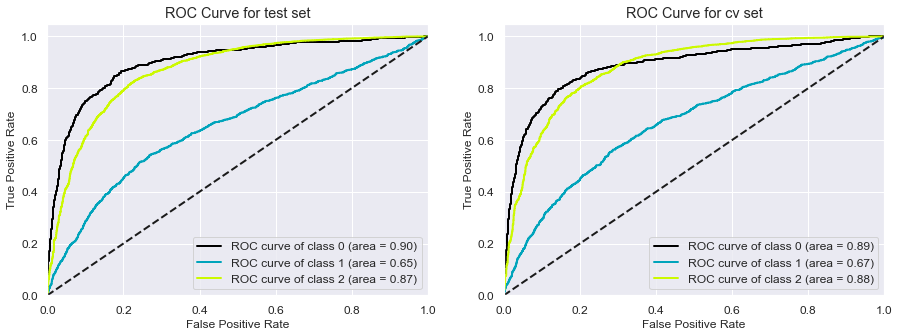

---------------------------------------- Confusion Matrix ----------------------------------------


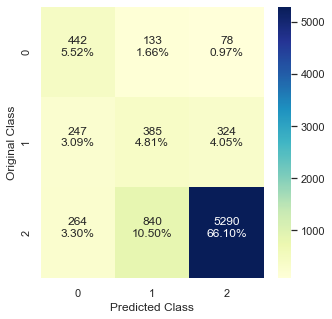

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


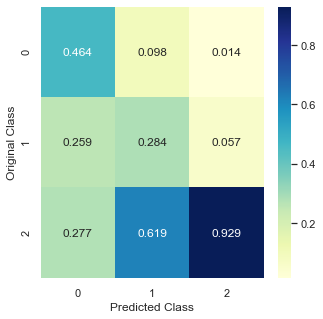

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


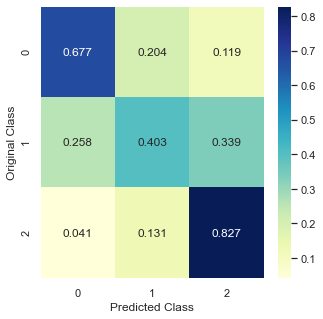

In [81]:
ll_svm_tr = log_loss(y_train, y_prob_tr, labels=cal_clf3.classes_, eps=1e-15)
ll_svm_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf3.classes_, eps=1e-15)
ll_svm_te = log_loss(y_test, y_prob, labels=cal_clf3.classes_, eps=1e-15)
roc_svm_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_svm_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_svm_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using SVM",ll_svm_tr)
print("Log loss on Cross Validation Data using SVM",ll_svm_cv)
print("Log loss on Test Data using SVM",ll_svm_te)
print("ROC-AUC Score on Train Data using SVM",roc_svm_tr)
print("ROC-AUC Score on Cross Validation Data using SVM",roc_svm_cv)
print("ROC-AUC Score on Test Data using SVM",roc_svm_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Decision Tress

### Hyperparameter Tuning

In [82]:
# Number of features to consider at every split
max_features = ['auto', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
params = { 'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}
clf4 = DecisionTreeClassifier(random_state=42)
r_search = RandomizedSearchCV(clf4, param_distributions=params, return_train_score=True, random_state=42)
r_search.fit(x_tr, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, return_train_score=True)

In [83]:
print(f'The best hyperparameter values is {r_search.best_params_} at which the score is {r_search.best_score_}')

The best hyperparameter values is {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 60} at which the score is 0.7858911697621375


### Training the model

In [84]:
clf4 = DecisionTreeClassifier(**r_search.best_params_)
clf4.fit(x_tr, y_train)
cal_clf4 = CalibratedClassifierCV(clf4, cv='prefit')
cal_clf4.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=60,
                                                             min_samples_split=5),
                       cv='prefit')

In [85]:
y_pred_tr = cal_clf4.predict(x_tr)
y_prob_tr = cal_clf4.predict_proba(x_tr)
y_pred_cv = cal_clf4.predict(x_cv)
y_prob_cv = cal_clf4.predict_proba(x_cv)
y_pred = cal_clf4.predict(x_te)
y_prob = cal_clf4.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Decision Trees 0.032662238248476076
Log loss on Cross Validation Data using Decision Trees 1.868239950068644
Log loss on Test Data using Decision Trees 1.9227725741048345
ROC-AUC Score on Train Data using Decision Trees 0.9997917755583776
ROC-AUC Score on Cross Validation Data using Decision Trees 0.669357170145647
ROC-AUC Score on Test Data using Decision Trees 0.6568349313145037


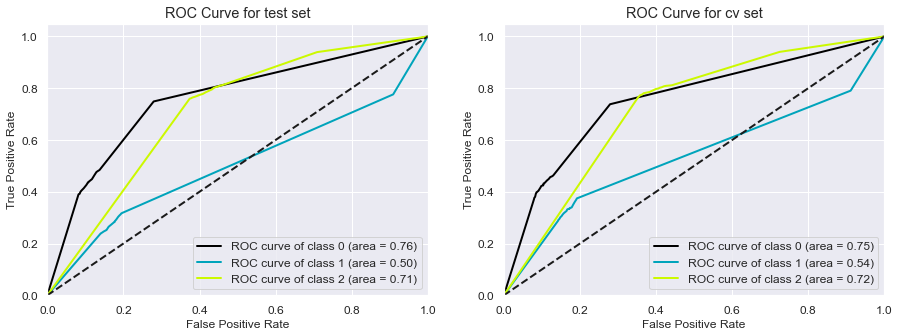

---------------------------------------- Confusion Matrix ----------------------------------------


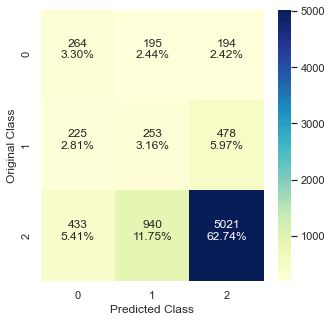

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


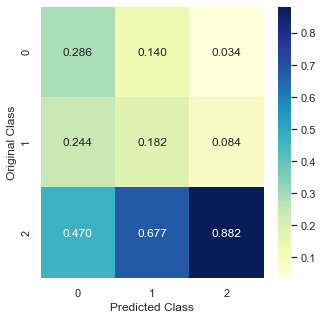

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


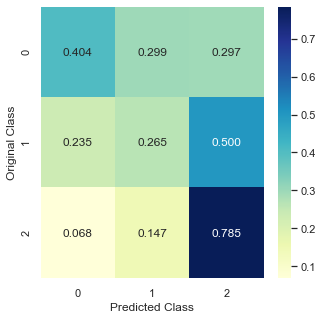

In [86]:
ll_dt_tr = log_loss(y_train, y_prob_tr, labels=cal_clf4.classes_, eps=1e-15)
ll_dt_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf4.classes_, eps=1e-15)
ll_dt_te = log_loss(y_test, y_prob, labels=cal_clf4.classes_, eps=1e-15)
roc_dt_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_dt_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_dt_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Decision Trees",ll_dt_tr)
print("Log loss on Cross Validation Data using Decision Trees",ll_dt_cv)
print("Log loss on Test Data using Decision Trees",ll_dt_te)
print("ROC-AUC Score on Train Data using Decision Trees",roc_dt_tr)
print("ROC-AUC Score on Cross Validation Data using Decision Trees",roc_dt_cv)
print("ROC-AUC Score on Test Data using Decision Trees",roc_dt_te)

#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

## Stacking Classifier

### Training the model

In [87]:
estimators = [('nb', clf2), ('svc', clf3), ('dt',  clf4)]

scl = StackingClassifier(estimators=estimators, final_estimator=clf1, n_jobs=-1)
scl.fit(x_tr, y_train)
cal_clf = CalibratedClassifierCV(scl, cv='prefit')
cal_clf.fit(x_tr, y_train)

CalibratedClassifierCV(base_estimator=StackingClassifier(estimators=[('nb',
                                                                      GaussianNB(var_smoothing=2.848035868435799e-08)),
                                                                     ('svc',
                                                                      SGDClassifier(alpha=1,
                                                                                    n_jobs=-1,
                                                                                    random_state=42)),
                                                                     ('dt',
                                                                      DecisionTreeClassifier(max_depth=60,
                                                                                             min_samples_split=5))],
                                                         final_estimator=SGDClassifier(alpha=1,
                                        

In [88]:
y_pred_tr = cal_clf.predict(x_tr)
y_prob_tr = cal_clf.predict_proba(x_tr)
y_pred_cv = cal_clf.predict(x_cv)
y_prob_cv = cal_clf.predict_proba(x_cv)
y_pred = cal_clf.predict(x_te)
y_prob = cal_clf.predict_proba(x_te)

### Performance of the model

Log loss on Train Data using Stacking Classifier 0.5739330238094433
Log loss on Cross Validation Data using Stacking Classifier 0.5869865299809621
Log loss on Test Data using Stacking Classifier 0.5951815634925102
ROC-AUC Score on Train Data using Stacking Classifier 0.9469244465912237
ROC-AUC Score on Cross Validation Data using Stacking Classifier 0.8180006070991902
ROC-AUC Score on Test Data using Stacking Classifier 0.8123186495895675


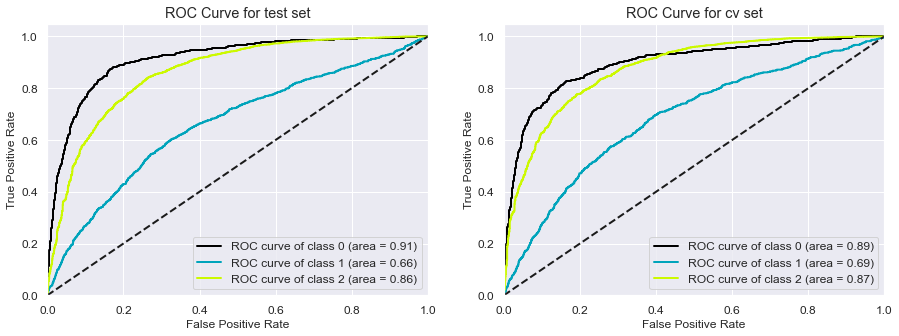

---------------------------------------- Confusion Matrix ----------------------------------------


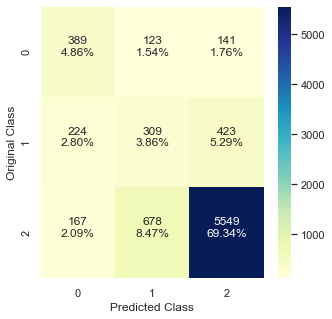

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


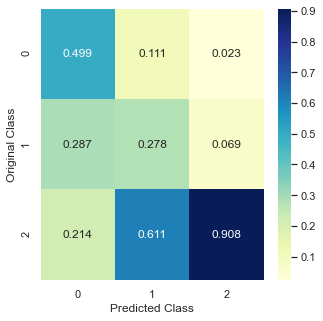

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


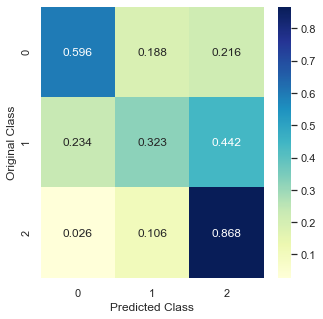

In [89]:
ll_sc_tr = log_loss(y_train, y_prob_tr, labels=cal_clf.classes_, eps=1e-15)
ll_sc_cv = log_loss(y_cv, y_prob_cv, labels=cal_clf.classes_, eps=1e-15)
ll_sc_te = log_loss(y_test, y_prob, labels=cal_clf.classes_, eps=1e-15)
roc_sc_tr = roc_auc_score(y_train, y_prob_tr, multi_class='ovr')
roc_sc_cv = roc_auc_score(y_cv, y_prob_cv, multi_class='ovr')
roc_sc_te = roc_auc_score(y_test, y_prob, multi_class='ovr')


print("Log loss on Train Data using Stacking Classifier",ll_sc_tr)
print("Log loss on Cross Validation Data using Stacking Classifier",ll_sc_cv)
print("Log loss on Test Data using Stacking Classifier",ll_sc_te)
print("ROC-AUC Score on Train Data using Stacking Classifier",roc_sc_tr)
print("ROC-AUC Score on Cross Validation Data using Stacking Classifier",roc_sc_cv)
print("ROC-AUC Score on Test Data using Stacking Classifier",roc_sc_te)


#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fig, axes = plt.subplots(1,2 , figsize=(15,5))

skplt.metrics.plot_roc_curve(y_test, y_prob, ax=axes[0], curves=('each_class'), figsize=(8,8), title='ROC Curve for test set')

skplt.metrics.plot_roc_curve(y_cv, y_prob_cv, ax=axes[1], curves=('each_class'), figsize=(8,8), title='ROC Curve for cv set')
plt.show()

cnf_matrix(y_test, y_pred)

# Summary of Result

In [90]:
table = PrettyTable()
table.field_names = ['Model', 'Train Log Loss', 'CV Log Loss', 'Test Log Loss', 'Train ROC-AUC', 'CV ROC-AUC', 'Test ROC-AUC']
table.add_rows([['Random Model', 'NA', round(ll_rm_cv,2), round(ll_rm_te,2), 'NA', round(roc_rm_cv,2), round(roc_rm_te,2)],
                ['Logistic Regression', round(ll_lg_tr,2), round(ll_lg_cv,2), round(ll_lg_te,2), round(roc_lg_tr,2), round(roc_lg_cv,2), round(roc_lg_te,2)],
                ['Naive Bayes', round(ll_nb_tr,2), round(ll_nb_cv,2), round(ll_nb_te,2), round(roc_nb_tr,2), round(roc_nb_cv,2), round(roc_nb_te,2)],
                ['SVM', round(ll_svm_tr,2), round(ll_svm_cv,2), round(ll_svm_te,2), round(roc_svm_tr,2), round(roc_svm_cv,2), round(roc_svm_te,2)],
                ['Decision Trees', round(ll_dt_tr,2), round(ll_dt_cv,2), round(ll_dt_te,2), round(roc_dt_tr,2), round(roc_dt_cv,2), round(roc_dt_te,2)],
                ['Stacking Classifier', round(ll_sc_tr,2), round(ll_sc_cv,2), round(ll_sc_te,2), round(roc_sc_tr,2), round(roc_sc_cv,2), round(roc_sc_te,2)]])

In [91]:
print('-'*47, 'TFIDF Vectorization', '-'*47)
table.set_style(DEFAULT)
print(table)

----------------------------------------------- TFIDF Vectorization -----------------------------------------------
+---------------------+----------------+-------------+---------------+---------------+------------+--------------+
|        Model        | Train Log Loss | CV Log Loss | Test Log Loss | Train ROC-AUC | CV ROC-AUC | Test ROC-AUC |
+---------------------+----------------+-------------+---------------+---------------+------------+--------------+
|     Random Model    |       NA       |     1.34    |      1.34     |       NA      |    0.51    |     0.51     |
| Logistic Regression |      0.72      |     0.69    |      0.69     |      0.86     |    0.81    |     0.81     |
|     Naive Bayes     |      1.05      |     1.04    |      1.03     |      0.66     |    0.72    |     0.72     |
|         SVM         |      0.74      |     0.69    |      0.69     |      0.86     |    0.81    |     0.81     |
|    Decision Trees   |      0.03      |     1.87    |      1.92     |      1.0

So our best model is **Logistic Regression with a ROC-AUC Score of 0.81 and log loss of 0.69**